In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Read the Excel file
excel_data = pd.ExcelFile("DS_task.xlsx")
#print(excel_data.sheet_names)
# Load data
df = excel_data.parse(sheet_name="STR_sample_data")  
#print(df.head())

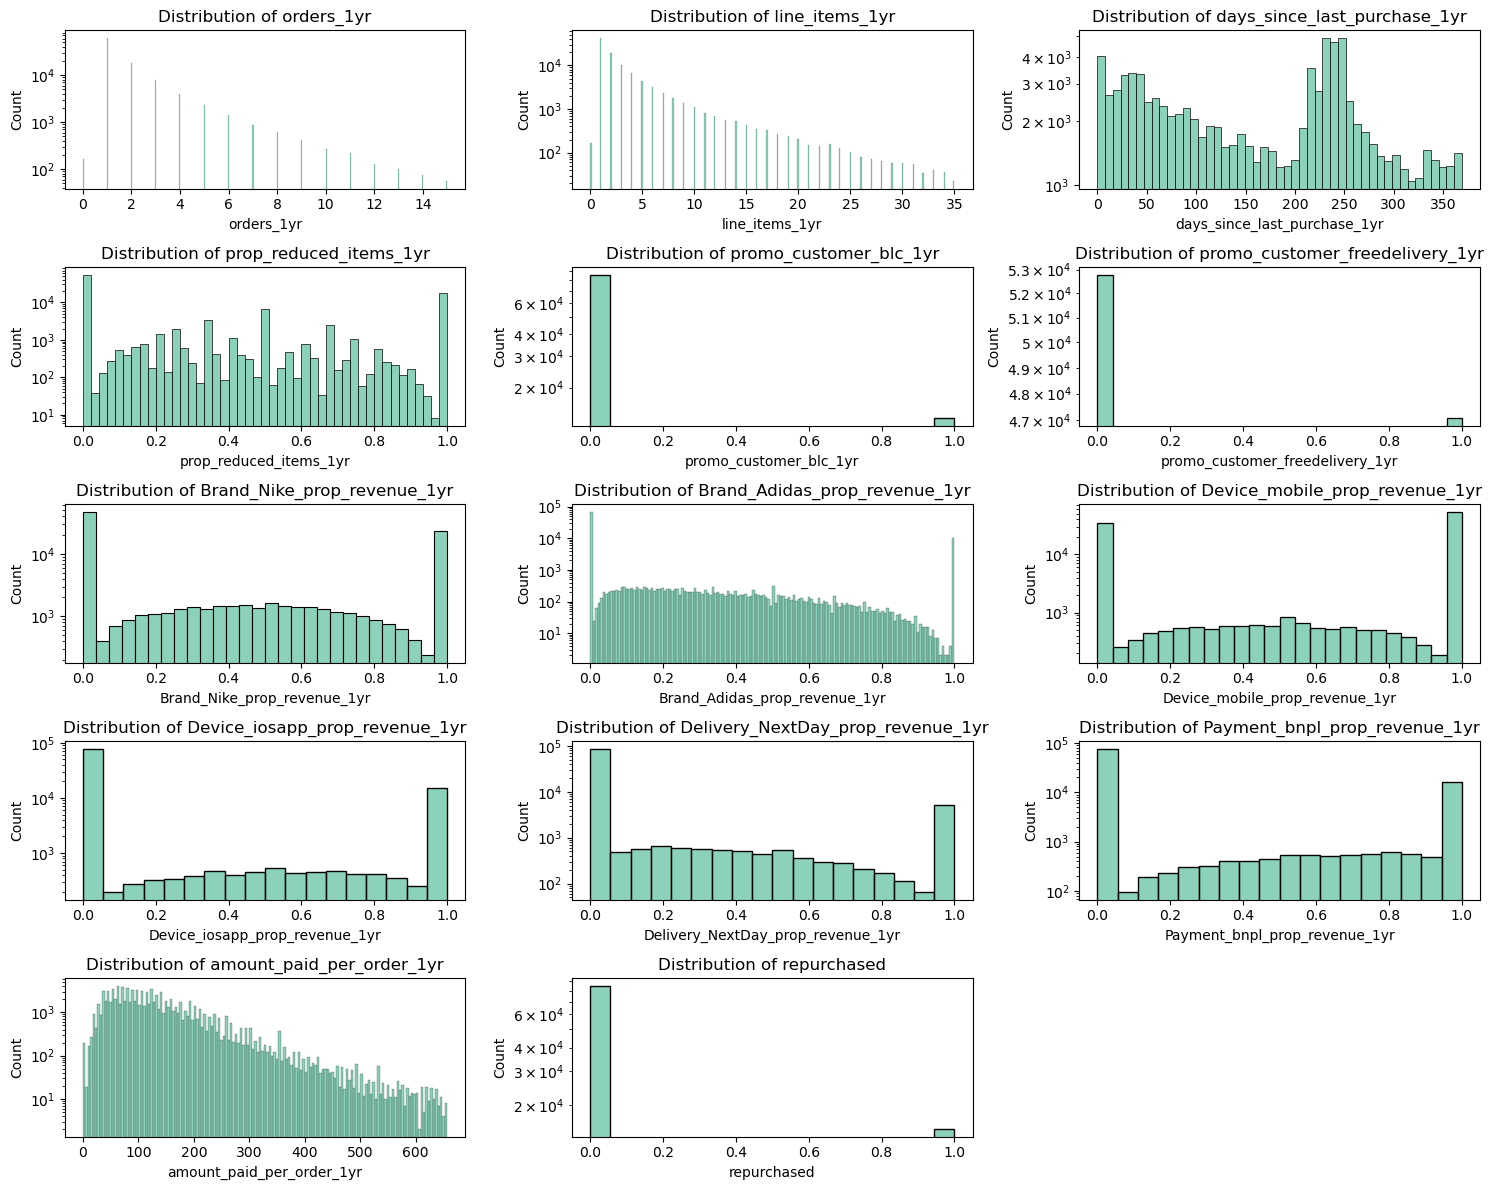

In [3]:
#dfc = df.drop(columns=['customer_site_id','Current_RFM_Segment','ONS_Segment']).dropna()
dfc = df.drop(columns=['customer_site_id']).dropna()
dfc = pd.get_dummies(dfc, columns=['Current_RFM_Segment','ONS_Segment'])
#dfc
#pd.concat([dfc, encoded], axis=1)

#dfc.describe()
#dfc = pd.get_dummies(dfc, drop_first=True) 
#dfc = dfc[(np.abs(stats.zscore(numeric_cols)) < 5).all(axis=1)]
numeric_cols = dfc.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_data = dfc.select_dtypes(include=['float64', 'int64'])
dfc = dfc[(np.abs(stats.zscore(numeric_cols_data)) < 5).all(axis=1)]
#dfc = numeric_cols[(np.abs(stats.zscore(dfc)) < 5).all(axis=1)]
# Check the shape of the cleaned dataset
#dfc.describe()

sns.set_palette("Set2") 
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i)
    ax = sns.histplot(dfc[col], kde=False)
    plt.title(f'Distribution of {col}')
    # Set the y-axis to logarithmic scale
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [4]:
dfc.columns[dfc.columns.str.contains('ONS')]

Index(['ONS_Segment_ONS_1', 'ONS_Segment_ONS_2', 'ONS_Segment_ONS_3',
       'ONS_Segment_ONS_4', 'ONS_Segment_ONS_5', 'ONS_Segment_ONS_6',
       'ONS_Segment_ONS_7', 'ONS_Segment_ONS_8', 'ONS_Segment_ONS_Unknown'],
      dtype='object')

In [5]:
dfc.columns[dfc.columns.str.contains('Current')]

Index(['Current_RFM_Segment_Existing_1. VIP',
       'Current_RFM_Segment_Existing_2. POTENTIALS',
       'Current_RFM_Segment_Existing_3. CASUALS / AVERAGE',
       'Current_RFM_Segment_Existing_4. LAPSED',
       'Current_RFM_Segment_Existing_5. DORMANT',
       'Current_RFM_Segment_New_1. VIP',
       'Current_RFM_Segment_New_2. POTENTIALS',
       'Current_RFM_Segment_New_3. CASUALS / AVERAGE',
       'Current_RFM_Segment_UNKNOWN'],
      dtype='object')

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Target variable (repurchase likelihood)
target = dfc['repurchased']  # Binary target variable (1 = repurchased, 0 = no repurchase)

def make_XY(variables):
    assert isinstance(variables, list)
    df_cut = dfc[variables]
    
    # Splitting the data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(df_cut, target, test_size=0.2, random_state=0, shuffle=True, stratify=target)
    return X_train, X_test, y_train, y_test

#### combining the corelated variables (or so called feature engineering) to avoid multicolinearity 
#### while classification model try to train on the data.
#### Decided to do the simple submission and not multiplication as they are most -ve corelated.
dfc['promo_combined']= dfc['promo_customer_freedelivery_1yr']+dfc['promo_customer_blc_1yr']
dfc['Brand_combined']= dfc['Brand_Adidas_prop_revenue_1yr']+dfc['Brand_Nike_prop_revenue_1yr']
dfc['Device_combined'] = dfc['Device_mobile_prop_revenue_1yr']+dfc['Device_iosapp_prop_revenue_1yr']

X_train, X_test, y_train, y_test = make_XY([
    'orders_1yr',
    'promo_combined', 
    'Brand_combined',
    'Device_combined',
    'Payment_bnpl_prop_revenue_1yr',
    'ONS_Segment_ONS_1', 'ONS_Segment_ONS_2', 'ONS_Segment_ONS_3',
    'ONS_Segment_ONS_4', 'ONS_Segment_ONS_5', 'ONS_Segment_ONS_6',
    'ONS_Segment_ONS_7', 'ONS_Segment_ONS_8', 'ONS_Segment_ONS_Unknown', 
    'Current_RFM_Segment_Existing_1. VIP',
    'Current_RFM_Segment_Existing_2. POTENTIALS',
    'Current_RFM_Segment_Existing_3. CASUALS / AVERAGE',
    'Current_RFM_Segment_Existing_4. LAPSED',
    'Current_RFM_Segment_Existing_5. DORMANT',
    'Current_RFM_Segment_New_1. VIP',
    'Current_RFM_Segment_New_2. POTENTIALS',
    'Current_RFM_Segment_New_3. CASUALS / AVERAGE',
    'Current_RFM_Segment_UNKNOWN'
])

2024-09-26 09:28:52.880370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
### checking class imbalance
from sklearn.utils import shuffle

# Assuming X_train and y_train are your features and labels
X_train = pd.DataFrame(X_train)  # Convert to DataFrame for easy manipulation
y_train = pd.Series(y_train)  # Convert to Series for easy manipulation

# Separate majority and minority classes
minority_class = X_train[y_train == 1]  # All samples from the minority class (label = 1)
majority_class = X_train[y_train == 0]  # All samples from the majority class (label = 0)

# Get the number of minority samples
n_minority = len(minority_class)

# Randomly sample from the majority class to match the minority class size
majority_class_downsampled = majority_class.sample(n=n_minority, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([minority_class, majority_class_downsampled])
y_train_balanced = pd.concat([y_train[y_train == 1], y_train[y_train == 0].sample(n=n_minority, random_state=42)])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Convert back to NumPy arrays for Keras compatibility
X_train_balanced = X_train_balanced.to_numpy()
y_train_balanced = y_train_balanced.to_numpy()

unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))


{0: 11866, 1: 11866}


In [8]:
#### Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [41]:
def build_dnn(input_dim,hiddenlayers,neurons,lr):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    for _ in range(hiddenlayers):
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))    
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.BinaryCrossentropy()
    metric =['accuracy']
    model.compile(optimizer=opt, loss=loss, metrics=metric)
    return model



In [42]:
#### Make the model 
input_dim = X_train_scaled.shape[1]  # Number of input features
model = build_dnn(input_dim,3,16,0.00001)

#### Adding Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitors the validation loss
    patience=5,            # Number of epochs to wait after no improvement
    restore_best_weights=True  # Restores the weights of the best epoch
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
history = model.fit(X_train_scaled, 
                    y_train_balanced, 
                    validation_data=(X_test_scaled,y_test),
                    epochs=75,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5309 - loss: 0.8842 - val_accuracy: 0.7462 - val_loss: 0.6049
Epoch 2/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5278 - loss: 0.8689 - val_accuracy: 0.7481 - val_loss: 0.5988
Epoch 3/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5362 - loss: 0.8480 - val_accuracy: 0.7519 - val_loss: 0.5897
Epoch 4/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5318 - loss: 0.8407 - val_accuracy: 0.7547 - val_loss: 0.5842
Epoch 5/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5318 - loss: 0.8343 - val_accuracy: 0.7565 - val_loss: 0.5817
Epoch 6/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5362 - loss: 0.8150 - val_accuracy: 0.7580 - val_loss: 0.5767
Epoch 7/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5470 - loss: 0.8028 - val_accuracy: 0.7619 - val_loss: 0.5772
Epoch 8/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5352 - loss: 0.8054 - val_accuracy: 0

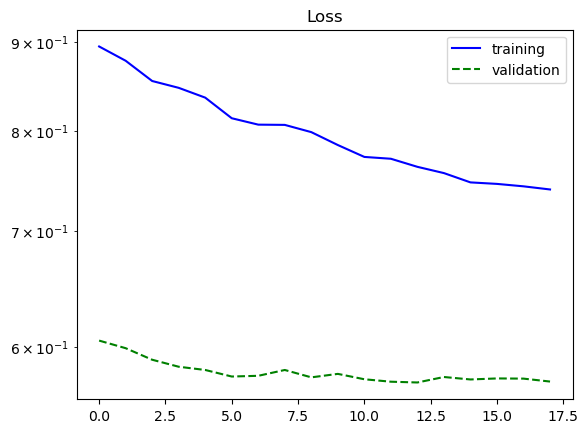

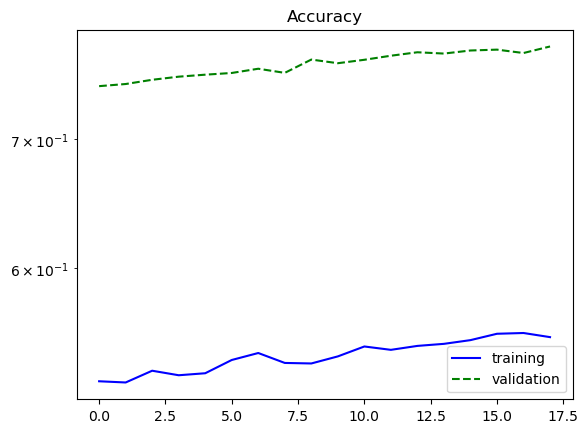

In [44]:
sns.lineplot(x=history.epoch, y=history.history['loss'],color='b',label='training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'],color='g',linestyle='--',label='validation')
plt.yscale('log')
plt.title('Loss')
plt.show()

sns.lineplot(x=history.epoch, y=history.history['accuracy'],color='b',label='training')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'],color='g',linestyle='--',label='validation')
plt.yscale('log')
plt.title('Accuracy')
plt.show()


In [45]:
#### Save the model
model.save('trained_model3.keras')

742/742 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


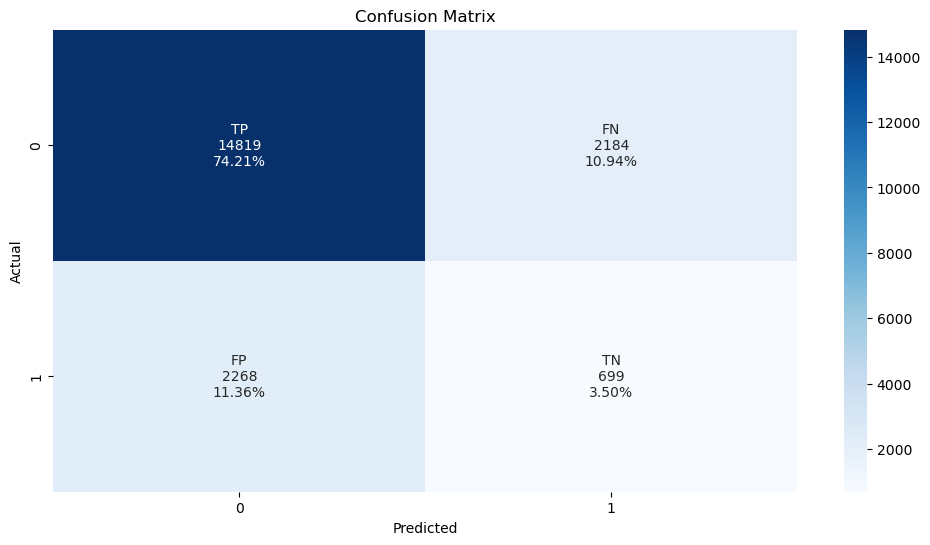

Total Accuracy: 0.78
In a test sample of size 19970
This Model will send total emails : 2883
Where Estimated misclassification cost (in Pounds) is : 4368.00


In [46]:
# Load the saved model
loaded_model = keras.models.load_model('trained_model3.keras')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Make predictions on the train and test sets
y_train_pred = loaded_model.predict(X_train_scaled).ravel()  # Predict probabilities for training set
y_test_pred = loaded_model.predict(X_test_scaled).ravel()    # Predict probabilities for test set

#### Convert predicted probabilities to class labels (0 or 1)
y_pred = np.round(y_test_pred).astype(int)  # For binary classification


# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
#print(f"Confusion Matrix:\n{cf_matrix}")

plt.figure(figsize=(12,6))
group_names = ['TP','FN','FP','TN']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
#print(f"Confusion Matrix:\n{conf_matrix_normalized}")
#sns.heatmap(conf_matrix_normalized , annot=True,   fmt='g', cmap='YlGnBu', linewidths=0.5, vmin=np.min(conf_matrix_normalized), vmax=np.max(conf_matrix_normalized))

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 0: when customer doesnt repurchase, 1 : when customer repurchases 
## TP : "when customer doesn't make a purchase and has been predicted so (0,0)"
## FN : "when customer actually made no purchase but model predicted he did (0,1)"
## FP : "when customer actually made a purchase but model predicted he didn't (1,0)"
## TN :  "when customer actually made a purchase but model predicted he did (1,1)"

# Extract values from the confusion matrix
TP, FN, FP, TN = cf_matrix.ravel()
#print("TP: ", TP, " FN: ", FN, "\nFP: ", FP, " TN: ",TN)

#### Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Total Accuracy: {accuracy:.2f}")


#### Calculate Misclassification Rate
#misclassification_rate = (FP + FN) / (TP + TN + FP + FN)
#print(f"Total Misclassification Rate: {misclassification_rate:.2f}")

print("In a test sample of size", len(y_test))
#### The customers that this model will send emails to is where model predicts 1, which will be total of FN and TN.
print(f"This Model will send total emails : {(FN+TN):d}") 

#### Calculate Misclassification Cost sent per email 
#### To look at this, we need to know how many times my model predicted that customer would repurchase but in reality he wont (This is FN)
CostPerEmail = 2 
misclassification_cost = (FN) * CostPerEmail
print(f"Where Estimated misclassification cost (in Pounds) is : {misclassification_cost:.2f}")

#### Calculate FP Rate
#False_Positive_rate = (FP)/ (TN + FP)
#print(f"FPR : {False_Positive_rate:.2f}")

#### Calculate TP Rate/Recall (Of all the actual positives, how many did the model correctly identify?")
#True_Positive_rate = (TP)/ (TP + FN)
#print(f"TPR/Recall : {True_Positive_rate:.2f}")


#### Precision :  "When the model predicts positive, how often is it corr" OR How many of the predicted positives were actually correct?
#Precision = TP/(TP+FP)
#print(f"Precision : {Precision:.2f}")

#### F1-score: harmonic mean of precision and recall (A balanced measure of precision and recall. Useful when you need a balance between the two.)
#F1_score = 2*Precision*True_Positive_rate/(Precision+True_Positive_rate)
#print(f"F1 Score : {F1_score:.2f}")

# Key Insights from DNN Binary Classification modelling with Categorical variables implemented too!

- Here, to deal with categorical variables, used one-hot encoding and added them as imput variables to the model.
- But overall, here the accuracy is 78% (78%) where in misidentification cost reduced to 4368 (5634) pounds (compared to without categorical variables).

|Model Architecture  | |
|-----|:----- | 
| Neurons | 16 For Input Layer (16 for Hidden layers) | 
| Layers  | 3 | 
| Optimizer | Adam | 
| Loss Function| BinaryCrossentropy | 
| Activation Function| Relu/Sigmoid | 
| Learning Rate| 0.00001 |



# Next things inline: 
- Make the model more sophisticated for categorical variables included in binary classification model!
    - More hyper-parameter tuning needed clearly looking how loss fuction/accuracy behaves as function of epochs!
    - One could do more sophisticated feature engineering with correlated variables
    - Work on more class imbalance techniques as currently the training data got undersampleed based on minority class in output class.
    - Investigate outliers, currently just taken out for simplicity
  
- In Simple Logestic regression
    - One could investigate the fit in logestic regression model with grid search algorithm
    - (more for myself), understand how to investigate overfitting
    - Here also, one could do more sophisticated feature engineering with correlated variables 
    - Investigate outliers, currently just taken out for simplicity
